In [2]:
# default_exp loaders

# Datasets, DataLoaders, Samplers

In [12]:
# export

from pathlib import Path

import random
import numpy as np
from natsort import natsorted

import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.core.transforms_interface import ImageOnlyTransform

In [4]:
# export
from lunglens.core import *
from lunglens.data import *

### Custom Augmentations

In [70]:
# export
def np_to_rgb_tensor(img):
    # add new dimention to get C x H x W
    # repeat color to get RBB
    rgb_image = np.repeat(img[np.newaxis, ...], 3, axis=0)
    return torch.FloatTensor(rgb_image)

# custom albumentation transformer
class ToColorTensor(ImageOnlyTransform):
    def __init__(self, always_apply=True, p=1):
        super().__init__(always_apply, p)
        
    def apply(self, img, **params):
        return np_to_rgb_tensor(img)

In [71]:
datasets_root = Path('../data/prepared')
all_slices = list(datasets_root.rglob('*.npy'))
len(all_slices)

51596

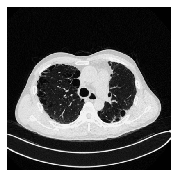

In [72]:
random_img_path = random.choice(all_slices)
random_img_path = '../data/prepared/osic-pulmonary-fibrosis-progression/ID00388637202301028491611/192.npy'
random_img = np.load(str(random_img_path))
print_slice(random_img, figsize=(3,3))

In [79]:
tfm = ToColorTensor()
rgb_img = tfm(image=random_img)['image']
rgb_img.shape

torch.Size([3, 400, 400])

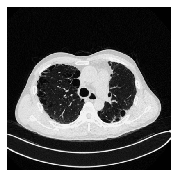

In [80]:
print_slice(rgb_img[0], figsize=(3,3))

### Basic dataset

Generates specified number of slices from one scans per one item. Length of the dataset is equal to the number of scans

In [115]:
# export

class RandomSlicerDataset(Dataset):
    def __init__(self, datasets_root, transform=None, slices_per_scan=4, inter_slice_distance=8):
        self.scans = list(Path(datasets_root).glob('*/*'))
        self.transform = transform
        self.slices_per_scan = slices_per_scan
        self.inter_slice_distance = inter_slice_distance
        
        self.slices_cache = {}

    def __len__(self):
        return len(self.scans)

    def __getitem__(self, idx):
        # idx can be an indexing slice or an index
        if isinstance(idx, slice):
            idx_range = range(len(self))[idx]
            
            return [self.get_item(idx) for idx in idx_range]
        else:
            return self.get_item(idx)
    
    def get_item(self, idx):
        scan_dir = self.scans[idx]

        if str(scan_dir) not in self.slices_cache:
            slices_files = map(str, scan_dir.glob('*.npy'))
            
            # natural sorting of files
            self.slices_cache[scan_dir] = np.array(natsorted(slices_files))
        
        slices_files = self.slices_cache[scan_dir]
        
        # calculate num of cobinations based on total items count, return count and step size
        cobinations_n = len(slices_files) - self.inter_slice_distance * (self.slices_per_scan - 1)
        
        # retrun slices according to config
        idx_first_slice = np.random.randint(cobinations_n)
        idx_list = idx_first_slice + self.inter_slice_distance * np.arange(self.slices_per_scan)
        
        random_slices = lmap(np.load, slices_files[idx_list])
        
        # augment two copies of selected random files 
        return self.aug(random_slices), self.aug(random_slices)
    
    def aug(self, slices):
        if self.transform:
            slices = [self.transform(image=s)['image'] for s in slices]
        
        return np.stack(slices)


In [116]:
# this just an example
tfms = A.Compose([
    A.Resize(512, 512),
    A.RandomCrop(384, 384),
    ToColorTensor()
])

In [117]:
dataset = RandomSlicerDataset(datasets_root, transform=tfms)
len(dataset)

175

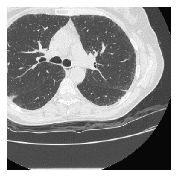

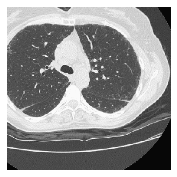

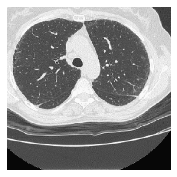

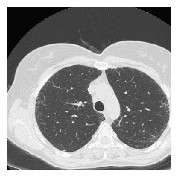

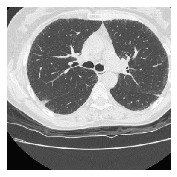

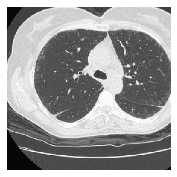

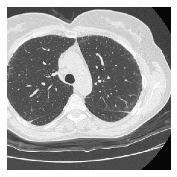

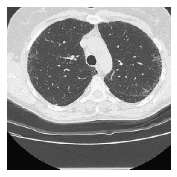

In [118]:
for slice_images in random.choice(dataset):
    for slice_img in slice_images:
        print_slice(slice_img[0], figsize=(3, 3))


#### Checking if caching is working
Enumerating the dicrectory is cached but slices loading is not because datasets are too big

In [119]:
%%time
for slices_batch in dataset[:10]:
    pass

Wall time: 1.17 s


In [120]:
%%time
for slices_batch in dataset[:10]:
    pass

Wall time: 1.33 s


#### Testing with default dataloader

In [121]:
batch_size = 8

loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True
)

#### Optionally we can squash per-scan batches into one batch

In [127]:
# export

# merge list of scans batches into one batch
# [N, M, ...] -> [N * M, ...]
def squash_scan_batches(superbatch):
    shape = np.array(superbatch.shape)
    
    # slices from all scans and all batches go to single batch
    shape[1] = shape[1] * shape[0]
    
    # drop first dimension
    return superbatch.view(*shape[1:])

# split batch of slices from N scans into N per-scan batches
# [N * M, ...] -> [N, M, ...]
def split_scans(superbatch, num_scans, num_slices):
    # add extra dimension
    shape = np.array([0] + list(superbatch.shape))

    shape[:2] = [num_scans, num_slices]

    return superbatch.view(*shape)

In [142]:
for superbatch0, superbatch1 in loader:
    break

In [143]:
src_shape = np.array(superbatch0.shape)

src_shape

array([  8,   4,   3, 384, 384])

In [144]:
reshaped_batch0 = squash_scan_batches(superbatch0)
reshaped_batch1 = squash_scan_batches(superbatch1)
print(reshaped_batch0.shape)

torch.Size([32, 3, 384, 384])


In [145]:
split_scans(reshaped_batch1, src_shape[0], src_shape[1]).shape

torch.Size([8, 4, 3, 384, 384])

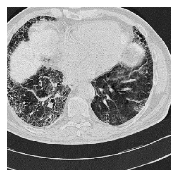

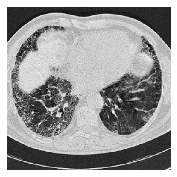

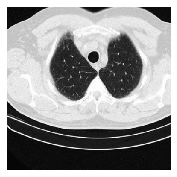

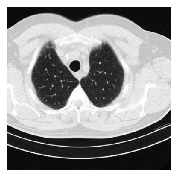

In [146]:
print_slice(superbatch0[0][1][0], figsize=(3, 3))
print_slice(superbatch1[0][1][0], figsize=(3, 3))
print_slice(superbatch0[1][1][0], figsize=(3, 3))
print_slice(superbatch1[1][1][0], figsize=(3, 3))

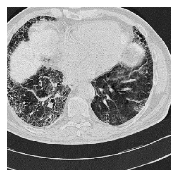

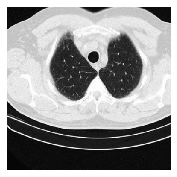

In [149]:
print_slice(reshaped_batch0[1][0], figsize=(3, 3))
print_slice(reshaped_batch0[4 + 1][0], figsize=(3, 3))